In [1]:
import retro
import time
import gym
import numpy as np
from gym import Env
from gym.spaces import Box, MultiBinary, Discrete
import numpy as np
import cv2
from matplotlib import pyplot as plt


#PPO for RL
from stable_baselines3 import PPO

from stable_baselines3.common.evaluation import evaluate_policy

from stable_baselines3.common.monitor import Monitor

from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack 
import os 




## Classe Sonic

In [2]:

BUTTONS = ['B', 'A', 'MODE', 'START', 'UP', 'DOWN', 'LEFT', 'RIGHT', 'C', 'Y', 'X', 'Z']

In [3]:
class Sonic(Env):
    def __init__(self):
        super().__init__()
        #travando o movimento do Sonic

        self.actions = [
            [],                    # Nada
            ['RIGHT'],             # Andar para frente
            ['LEFT'],              # Voltar
            ['A'],                 # Pular
            ['RIGHT', 'A'],        # Andar + Pular
            ['DOWN'],              # Agachar
            ['DOWN', 'A'],         # Spindash
            ['LEFT', 'A'],         # Voltar + Pular
        ]
        self._actions = []
        for combo in self.actions:
            arr = np.array([False] * len(BUTTONS))
            for btn in combo:
                arr[BUTTONS.index(btn)] = True
            self._actions.append(arr)

        self.action_space = Discrete(len(self._actions))





        #Fazendo a scaling da janela
        self.observation_space = Box(low = 0 , high = 255, shape =(84, 84, 1), dtype= np.uint8)
       
        

        #Criando a instancia do game
        self.game = retro.make(game='SonicAndKnuckles3-Genesis', use_restricted_actions = retro.Actions.FILTERED)
       
       
    def step(self, action):
        real_moves = self._actions[action]
        obs, _, done, info = self.game.step(real_moves)

        # Processa a observação
        obs = self.preprocess(obs)

        frame_delta = (obs - self.previous_frame) * 100
        self.previous_frame = obs


        v = info['x'] - self.x                      # avanço horizontal
        c = -0.1                                   # leve penalidade por tempo (evita ficar parado)
        d = -5 if info['lives'] < self.lives else 0  # penalidade forte por morrer

        reward = v * 0.01 + c + d                   # combinação escalada

        # --- Recompensa por coletar anéis ---
        delta_rings = info['rings'] - self.rings
        if delta_rings > 0:
            reward += delta_rings * 0.01
        elif delta_rings < 0:
            reward -= abs(delta_rings) * 0.01

        # --- Recompensa por aumento de score ---
        delta_score = info['score'] - self.score
        reward += delta_score * 0.0005

        # --- Recompensa por fim de fase ---
        reward += info.get('level_end_bonus', 0) * 0.0005

        # --- Verificação de travamento ---
        delta_x = info['x'] - self.x
        if delta_x > 0:
            self.stuck_steps = 0
        else:
            self.stuck_steps += 1

        if self.stuck_steps >= 900:
            reward -= 0.2  # penalidade por ficar parado muito tempo

        if self.stuck_steps >= 1200:
            done = True   # finaliza episódio se travado muito tempo

        # --- Atualização dos estados ---
        self.x = info['x']
        self.rings = info['rings']
        self.score = info['score']
        self.lives = info['lives']
        
        
        return frame_delta, reward, done, info



      
    def render(self, *args, **kwargs):
        frame = self.game.get_screen()
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # retro retorna RGB, OpenCV espera BGR
        cv2.imshow("Sonic", frame)
        cv2.waitKey(1)

    def reset(self, *, seed = None, options = None):
        #retorna o primeiro frame
        obs = self.game.reset()
        obs = self.preprocess(obs)
        
        #processa 
        self.previous_frame = obs
        #score delta (score do delta do frame - score do frame que foi)
        self.lives = 3
        self.x = 0 
        self.rings = 0
        self.score = 0 
        self.stuck_steps = 0
        self.delta_max_x = 0


        return obs
    
     
    def preprocess(self,observation):
        #grayscaling
        gray = cv2.cvtColor(observation,cv2.COLOR_BGR2GRAY)

        #resize
        resize = cv2.resize(gray, (84,84), interpolation= cv2.INTER_CUBIC)

        #add the channels value (volta pro original)
        channels = np.reshape(resize,(84,84,1))
        return channels
    

    def close(self):
        self.game.close()

## Wrapper de memória

In [4]:
class StickyActionWrapper(gym.Wrapper):
    def __init__(self, env, repeat=4):
        super().__init__(env)
        self.repeat = repeat
        self.last_action = None

    def step(self, action):
        total_reward = 0
        done = False
        for _ in range(self.repeat):
            obs, reward, done, info = self.env.step(action if self.last_action is None else self.last_action)
            total_reward += reward
            if done:
                break
        self.last_action = action
        return obs, total_reward, done, info

    def reset(self, **kwargs):
        self.last_action = None
        return self.env.reset(**kwargs)


## Classe Zigzag

In [5]:
class SonicZigZag(Sonic):
    def __init__(self):
        super().__init__()
        #fecha se não dá prob
        self.game.close() 
        #Criando a instancia do game
        self.game = retro.make(game='SonicAndKnuckles3-Genesis', use_restricted_actions = retro.Actions.FILTERED)

        self.max_x = 0
        self.jump_counter = 0
        
    
    def in_pre_trampoline_zone(self, info):
        x, y = info['x'], info['y']
        return 10600 <= x <= 10615 and 1110 <= y <= 1122

    def in_post_trampoline_zone(self, info):
        return info['x'] >= 10630

    def in_zigzag_zone(self, info):
        return 11100 <= info['x'] <= 11400 and info['y'] <= 970
    


    def step(self, action):
        real_moves = self._actions[action]
        obs, _, done, info = self.game.step(real_moves)

        # Processa a observação
        obs = self.preprocess(obs)
        frame_delta = (obs - self.previous_frame) * 100
        self.previous_frame = obs

        # Recompensa base
        v = info['x'] - self.x
        c = -0.1
        d = -5 if info['lives'] < self.lives else 0
        reward = v * 0.01 + c + d

        # --- Recompensas padrão ---
        delta_rings = info['rings'] - self.rings
        if delta_rings > 0:
            reward += delta_rings * 0.01
        elif delta_rings < 0:
            reward -= abs(delta_rings) * 0.01

        delta_score = info['score'] - self.score
        reward += delta_score * 0.0005

        reward += info.get('level_end_bonus', 0) * 0.0005

        # --- Zona pré-trampolim ---
        if self.in_pre_trampoline_zone(info):
            if real_moves[BUTTONS.index('LEFT')]:
                reward += 0.2
            else:
                reward -= 0.05

        # --- Zona pós-trampolim / Zig-zag ---
        if self.in_zigzag_zone(info):
            segurando_right = real_moves[BUTTONS.index('RIGHT')]
            pulando = (
                real_moves[BUTTONS.index('A')] 
                
            )

            
            if segurando_right:
                reward += 0.3
            
            else:
                reward -= 0.5

            if pulando:
                reward -= 0.5

        # --- Verificação de travamento ---
        delta_x = info['x'] - self.x
        if delta_x > 0:
            self.stuck_steps = 0
        else:
            self.stuck_steps += 1

        if self.stuck_steps >= 900:
            reward -= 0.2

        if self.stuck_steps >= 1200:
            done = True

        # Atualização de estados
        self.x = info['x']
        self.rings = info['rings']
        self.score = info['score']
        self.lives = info['lives']

        return frame_delta, reward, done, info

    
    def close(self):
        self.game.close()


## Testando o agente randomico


--- Iniciando Episódio 1 ---
Fim do Episódio 1: Limite de tempo (5 minutos) atingido!
Recompensa Total: -822.02
Informações do episódio: {'x': 8789, 'lives': 1, 'level_end_bonus': 0, 'rings': 7, 'score': 50, 'zone': 0, 'act': 0, 'screen_x_end': 24576, 'screen_y': 1067, 'y': 1136, 'screen_x': 8629, 'special_stage': 0}


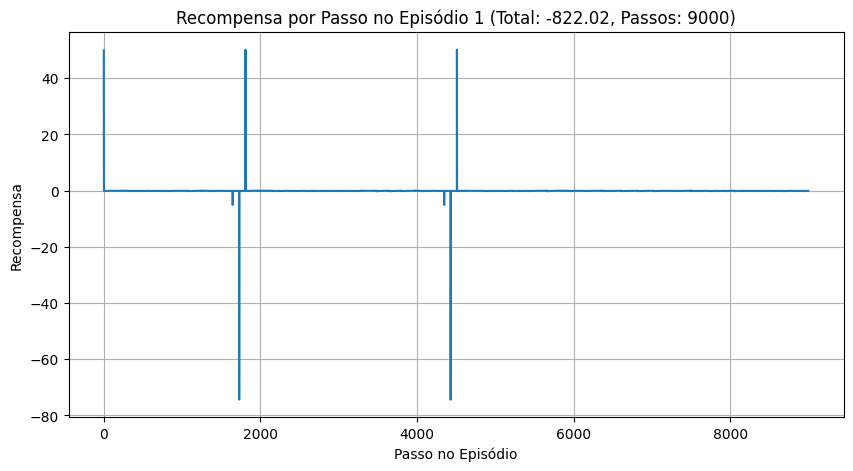


Todos os episódios concluídos.


In [6]:
env = SonicZigZag()
#anda e pula
POSSIBLE_ACTIONS_INDICES = [1, 4] # Andar para frente ou andar e pular

num_episodes = 1
all_episode_rewards = []


MAX_STEPS_PER_EPISODE = 9000 

for episode in range(num_episodes):
    obs = env.reset()
    done = False
    episode_reward = 0
    rewards_history = []
    current_steps = 0 # Contador de passos para o limite de tempo

    print(f"\n--- Iniciando Episódio {episode + 1} ---")
    #duração máxima de +-5 minutos
    while not done and current_steps < MAX_STEPS_PER_EPISODE: 
        env.render()
        action_to_take_index = np.random.choice(POSSIBLE_ACTIONS_INDICES) 
        
        obs, reward, done, info = env.step(action_to_take_index)
        
        episode_reward += reward
        rewards_history.append(reward)
        current_steps += 1 
        
        if done or current_steps >= MAX_STEPS_PER_EPISODE: 
            if current_steps >= MAX_STEPS_PER_EPISODE and not done:
                print(f"Fim do Episódio {episode + 1}: Limite de tempo (5 minutos) atingido!")
                done = True # Garante que o loop interno pare
            else:
                print(f"Fim do Episódio {episode + 1}: Condição de fim de jogo atingida.")
            
            print(f"Recompensa Total: {episode_reward:.2f}")
            print(f"Informações do episódio: {info}")
            all_episode_rewards.append(rewards_history)
            
            plt.figure(figsize=(10, 5))
            plt.plot(rewards_history)
            plt.title(f'Recompensa por Passo no Episódio {episode + 1} (Total: {episode_reward:.2f}, Passos: {current_steps})')
            plt.xlabel('Passo no Episódio')
            plt.ylabel('Recompensa')
            plt.grid(True)
            plt.show()

env.close()
print("\nTodos os episódios concluídos.")

cv2.destroyAllWindows()


## Vendo o ator jogar treinado

In [ ]:
env.close()

In [6]:
LOG_DIR = './logs/'
OPT_DIR = './opt/'

In [7]:
# Criação do ambiente personalizado
env = SonicZigZag()
env = StickyActionWrapper(env, repeat=4)
env = Monitor(env, LOG_DIR)  # salva estatísticas
# DummyVecEnv recebe uma lista de callables que retornam o env
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')  # empilhamento de frames

In [8]:
model = PPO.load('./train_zigs/best_model_13030000_zigzag')

In [9]:
mean_reward, _ = evaluate_policy(model,env,render = True , n_eval_episodes= 3 )

In [10]:
mean_reward

-308.02